In [73]:
import pandas as pd
import glob
import numpy as np
import cv2

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

from sklearn.preprocessing import StandardScaler

In [74]:
path = "dataset/images/train"
all_files = glob.glob(path + "/*.csv")
df_list = [pd.read_csv(file) for file in all_files]
train_df = pd.concat(df_list, ignore_index=True)

path = "dataset/images/validation"
all_files = glob.glob(path + "/*.csv")
df_list = [pd.read_csv(file) for file in all_files]
valid_df = pd.concat(df_list, ignore_index=True)

path = "dataset/images/test"
all_files = glob.glob(path + "/*.csv")
df_list = [pd.read_csv(file) for file in all_files]
test_df = pd.concat(df_list, ignore_index=True)

print('Total Train : '+str(len(train_df)))
print('Total Validation : '+str(len(valid_df)))
print('Total Test : '+str(len(test_df)))

Total Train : 25343
Total Validation : 6649
Total Test : 1792


In [75]:
X_train = train_df.iloc[:, 2:].values
X_train_image = train_df.iloc[:, 0].values
y_train = train_df.iloc[:, 1].values

X_valid = valid_df.iloc[:, 2:].values
X_valid_image = valid_df.iloc[:, 0].values
y_valid = valid_df.iloc[:, 1].values

X_test = test_df.iloc[:, 2:].values
X_test_image = test_df.iloc[:, 0].values
y_test = test_df.iloc[:, 1].values

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.fit_transform(y_valid)
y_test = label_encoder.fit_transform(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [76]:
expression_dict = {i: label for i, label in enumerate(label_encoder.classes_)}
print(expression_dict)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [77]:
def load_and_preprocess_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (48, 48))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=-1)
    return image

In [78]:
class DualInputDataGenerator(Sequence):
    def __init__(self, image_paths, landmarks, labels, path_directory='', batch_size=32, shuffle=True):
        self.image_paths = image_paths
        self.landmarks = landmarks
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.path_directory = path_directory
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        image_paths_batch = self.image_paths[indices]
        landmarks_batch = self.landmarks[indices]
        labels_batch = self.labels[indices]
        
        X_images = np.array([load_and_preprocess_image(f"{self.path_directory}/{expression_dict[label]}/{path}") for path, label in zip(image_paths_batch, labels_batch)])
        return [X_images, landmarks_batch], labels_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_generator = DualInputDataGenerator(X_train_image, X_train, y_train, 'dataset/images/train/', 16)
val_generator = DualInputDataGenerator(X_valid_image, X_valid, y_valid, 'dataset/images/validation/', 16, shuffle=False)
test_generator = DualInputDataGenerator(X_test_image, X_test, y_test, 'dataset/images/test/', 16, shuffle=False)

(16, 48, 48, 1) (16, 1404)


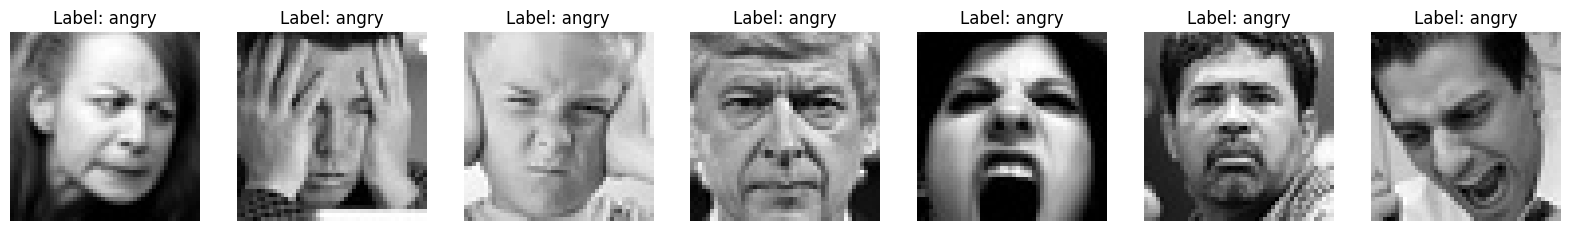

In [79]:
import matplotlib.pyplot as plt

def plot_images_from_generator(generator, num_images=7):
    data = next(iter(generator))
    images, landmarks = data[0]
    print(images.shape, landmarks.shape)
    labels = data[1]

    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        img = images[i].squeeze()
        landmark = landmarks[i]
        label = label_encoder.inverse_transform([labels[i]])[0]

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

plot_images_from_generator(val_generator)

In [80]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

image_input = Input(shape=(48, 48, 1))
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
image_output = Dense(64, activation='relu')(x)

landmarks_input = Input(shape=(X_train.shape[1],))
y = Dense(512, activation='relu')(landmarks_input)
y = Dropout(0.5)(y)
y = Dense(256, activation='relu')(y)
y = Dropout(0.5)(y)
y = Dense(128, activation='relu')(y)
y = Dropout(0.5)(y)
landmarks_output = Dense(64, activation='relu')(y)

combined = concatenate([image_output, landmarks_output])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(len(label_encoder.classes_), activation='softmax')(z)

In [81]:
model = Model(inputs=[image_input, landmarks_input], outputs=z)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 46, 46, 32)   320         ['input_18[0][0]']               
                                                                                                  
 input_19 (InputLayer)          [(None, 1404)]       0           []                               
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 23, 23, 32)  0           ['conv2d_16[0][0]']              
 )                                                                                          

In [82]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=0.0001)

In [83]:
history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1583/1583 [==============================] - 11s 7ms/step - loss: 1.8732 - accuracy: 0.2457 - val_loss: 1.7968 - val_accuracy: 0.2702 - lr: 0.0010
Epoch 2/50
1583/1583 [==============================] - 10s 6ms/step - loss: 1.7771 - accuracy: 0.2727 - val_loss: 1.6357 - val_accuracy: 0.3702 - lr: 0.0010
Epoch 3/50
1583/1583 [==============================] - 10s 6ms/step - loss: 1.6591 - accuracy: 0.3408 - val_loss: 1.5449 - val_accuracy: 0.4086 - lr: 0.0010
Epoch 4/50
1583/1583 [==============================] - 10s 6ms/step - loss: 1.6002 - accuracy: 0.3791 - val_loss: 1.4925 - val_accuracy: 0.4357 - lr: 0.0010
Epoch 5/50
1583/1583 [==============================] - 10s 6ms/step - loss: 1.5574 - accuracy: 0.3975 - val_loss: 1.4583 - val_accuracy: 0.4491 - lr: 0.0010
Epoch 6/50
1583/1583 [==============================] - 10s 6ms/step - loss: 1.5244 - accuracy: 0.4092 - val_loss: 1.4214 - val_accuracy: 0.4511 - lr: 0.0010
Epoch 7/50
1583/1583 [==============================

In [84]:
model.evaluate(test_generator, verbose=1)

112/112 [==============================] - 11s 95ms/step - loss: 1.4672 - accuracy: 0.4548


[1.4672272205352783, 0.4547991156578064]

In [85]:
model.save('dualInputModel.h5')

---

# Keras Tuner Framework

In [88]:
import kerastuner as kt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model

def build_model(hp):
    image_input = Input(shape=(48, 48, 1))
    x = Conv2D(hp.Int('filters_1', min_value=16, max_value=64, step=16), (3, 3), activation='relu')(image_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(hp.Int('filters_2', min_value=32, max_value=128, step=32), (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(hp.Int('units_1', min_value=64, max_value=256, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.6, step=0.1))(x)
    image_output = Dense(64, activation='relu')(x)

    landmarks_input = Input(shape=(X_train.shape[1],))
    y = Dense(hp.Int('units_2', min_value=128, max_value=512, step=128), activation='relu')(landmarks_input)
    y = Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.6, step=0.1))(y)
    landmarks_output = Dense(64, activation='relu')(y)

    combined = concatenate([image_output, landmarks_output])
    z = Dense(hp.Int('units_3', min_value=64, max_value=256, step=64), activation='relu')(combined)
    z = Dropout(hp.Float('dropout_3', min_value=0.3, max_value=0.6, step=0.1))(z)
    z = Dense(len(label_encoder.classes_), activation='softmax')(z)

    model = Model(inputs=[image_input, landmarks_input], outputs=z)
    
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd']), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='intro_to_kt')

tuner.search(train_generator, validation_data=val_generator, epochs=10)

best_model = tuner.get_best_models(num_models=1)[0]


Trial 4 Complete [00h 05m 59s]
val_accuracy: 0.5348895390828451

Best val_accuracy So Far: 0.5348895390828451
Total elapsed time: 00h 23m 35s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
48                |16                |filters_1
96                |32                |filters_2
256               |192               |units_1
0.5               |0.5               |dropout_1
128               |384               |units_2
0.3               |0.5               |dropout_2
256               |256               |units_3
0.5               |0.5               |dropout_3
adam              |adam              |optimizer

Epoch 1/10
1372/1583 [=========================>....] - ETA: 1s - loss: 1.6590 - accuracy: 0.3617

KeyboardInterrupt: 